In [1]:
"""
Author: Samuel Bell (sjb326@cam.ac.uk) 
jia_grating.py Copyright (c) 2020. All rights reserved.
This file may not be used or modified without the author's explicit written permission.
These files are hosted at https://gitlab.com/samueljamesbell/vpl-modelling. All other locations are mirrors of the original repository.

This file is a Python port of stimuli developed by Ke Jia.
"""

import math

import numpy as np
from PIL import Image

from random import random
from scipy.stats import norm
from numpy.random import binomial

from numpy import pi


_BLACK = 0
_WHITE = 255
_GRAY = round((_WHITE + _BLACK) / 2)


class JiaGrating:

    def __init__(self, ori_deg, size, outer_radius, inner_radius, pixel_per_degree, grating_contrast, phase, jitter=0, snr=1.0, spatial_frequency=None):
        self.ori_deg = ori_deg
        self.size = size

        self.outer_radius = outer_radius
        self.inner_radius = inner_radius
        self.pixel_per_degree = pixel_per_degree
        self.grating_contrast = grating_contrast
        self.phase = phase
        self.jitter = jitter
        self.snr = snr

        self.smooth_sd = self.pixel_per_degree / 6
        self.spatial_freq = spatial_frequency or (1 / self.pixel_per_degree)
        self.grating_size = round(self.outer_radius * self.pixel_per_degree)
        self.angle = ((self.ori_deg + self.jitter) - 90) / 180 * math.pi

    def image(self):
        x, y = np.mgrid[-self.grating_size:self.grating_size+1., -self.grating_size:self.grating_size+1.]

        d = self.grating_size * 2 + 1
        annulus = np.ones((d, d))

        edge_control = np.divide(np.sqrt(np.power(x, 2) + np.power(y, 2)), self.pixel_per_degree)

        overrado = np.nonzero(edge_control > self.inner_radius)

        for idx_x, idx_y in zip(*overrado):
            annulus[idx_x, idx_y] = annulus[idx_x, idx_y] * np.exp(-1 * ((((edge_control[idx_x, idx_y] - self.inner_radius) * self.pixel_per_degree) ** 2) / (2 * (self.smooth_sd ** 2))))    

        gabor_sti = _GRAY * (1 + self.grating_contrast * np.cos(2 * math.pi * self.spatial_freq * (y * np.sin(self.angle) + x * np.cos(self.angle)) + self.phase))

        gabor_sti[np.sqrt(np.power(x, 2) + np.power(y, 2)) > self.grating_size] = _GRAY

        # Noise
        noise = np.floor(np.sin(norm.rvs(size=(d, d))) * _GRAY) + _GRAY

        noise_mask = binomial(1, 1-self.snr, size=(d, d)).astype(int)
        masked_noise = noise * noise_mask

        signal_mask = 1 - noise_mask
        masked_gabor_sti = signal_mask * gabor_sti

        noisy_gabor_sti = masked_gabor_sti + masked_noise
        # End noise

        gabor_sti_final = np.repeat(noisy_gabor_sti[:, :, np.newaxis], 3, axis=-1)
        alpha_channel = annulus * _WHITE
        gabor_sti_final_with_alpha = np.concatenate((gabor_sti_final, alpha_channel[:, :, np.newaxis]), axis=-1)
        gabor_sti_final_with_alpha_image = Image.fromarray(gabor_sti_final_with_alpha.astype(np.uint8))

        center_x = int(self.size / 2)
        center_y = int(self.size / 2)
        bounding_box = (center_x - self.grating_size, center_y - self.grating_size)

        background = np.full((self.size, self.size, 3), _GRAY, dtype=np.uint8)
        final_image = Image.fromarray(background)

        final_image.paste(gabor_sti_final_with_alpha_image, box=bounding_box, mask=gabor_sti_final_with_alpha_image)

        return final_image



In [36]:
test_grating=JiaGrating(ori_deg=0, size=227, outer_radius=20, inner_radius=5, pixel_per_degree=19.19, grating_contrast=0.8, phase=0, spatial_freq=None)

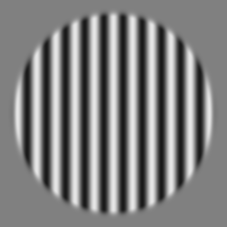

In [39]:
test_grating.image()